In [6]:
import argparse
import copy
import json
import math
import os
from collections import defaultdict
from itertools import chain, repeat
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
import torchvision
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import (BatchSampler, DataLoader, Dataset,
							  SequentialSampler)
from torch.utils.data.sampler import BatchSampler, Sampler
from torch.utils.model_zoo import tqdm
from torchvision.ops import box_iou
from tqdm import tqdm
from yaml import parse

from models import build_model
from copy import deepcopy

transform = T.Compose([
	T.Resize(800),
	T.ToTensor(),
	T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def create_heat_map(img_size, bboxs, weights):
	hmap = torch.zeros(img_size[1], img_size[0]).double().cuda()
	weights = weights.double().cuda()
	assert bboxs.shape[0] == weights.shape[0]
	normed_weights = weights/sum(weights)
	for this_box, this_weight in zip(bboxs, normed_weights):
		x1,y1,x2,y2 = [int(e) for e in this_box.tolist()]
		cov = (x2-x1)*(y2-y1)
		if cov <= 0:
			continue
		hmap[y1:y2, x1:x2] += this_weight/((x2-x1)*(y2-y1))
	if torch.sum(hmap) == 0:
		return torch.ones_like(hmap)/(hmap.shape[0]*hmap.shape[1])
	hmap /= torch.sum(hmap)
	return hmap

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
	x_c, y_c, w, h = x.unbind(1)
	b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
		 (x_c + 0.5 * w), (y_c + 0.5 * h)]
	return torch.stack(b, dim=1)

def box_coco_to_xyxy(bbox):
	[x, y, w, h] = bbox
	return [x,y,x+w, y+h]
	
def rescale_bboxes(out_bbox, size):
	img_w, img_h = size
	b = box_cxcywh_to_xyxy(out_bbox)
	b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
	return b


def mean(ls):
	return sum(ls)/len(ls)

def geo_mean(ls):
	return math.exp(sum([math.log(i) for i in ls])/len(ls))

def calc_matching_score_ANY_PROTOCOL(GT_bboxs, interested_bboxs):
	ious = box_iou(interested_bboxs, GT_bboxs)
	any_results = []
	correct = 0
	for ious_for_this in ious:
		any_results.append(float(ious_for_this.max()))
	return any_results

def merge_bboxs(bboxs):
	tensor_boxs = bboxs # (N, 4)
	xmin = tensor_boxs[:, 0].min()
	ymin = tensor_boxs[:, 1].min()
	xmax = tensor_boxs[:, 2].max()
	ymax = tensor_boxs[:, 3].max()
	return torch.tensor([xmin, ymin, xmax, ymax], device=device)

def calc_matching_score_ALL_PROTOCOL(GT_bboxs, interested_bboxs):
	if len(interested_bboxs) == 0:
		return 0
	GT_big_box = merge_bboxs(GT_bboxs)
	Interested_big_box = merge_bboxs(interested_bboxs)
	# print(GT_big_box)
	# print(Interested_big_box)
	return box_iou(Interested_big_box[None], GT_big_box[None]).float()

class LG_Dataset(Dataset):
	def __init__(self, annotation, flickr_img_dir, coco_img_dir, gqa_img_dir, return_img: True):
		self.return_img = return_img
		if type(annotation) == str:
			with open(annotation, 'r') as f:
				self.data = json.load(f)
		else:
			self.data = annotation
		self.flickr_img_dir = flickr_img_dir
		self.coco_img_dir = coco_img_dir
		self.gqa_img_dir = gqa_img_dir

	def __len__(self):
		return len(self.data['tests'])
	
	def get_height_and_width(self, idx):
		this_info =  self.data['grounding_pairs'][self.data['tests'][idx]['pair_id']]['data']['img_info']
		return this_info['height'], this_info['width']

	def __getitem__(self, idx):
		# lang-part
		pair_id = self.data['tests'][idx]['pair_id']
		pair_info = self.data['grounding_pairs'][pair_id]
		assert pair_id == pair_info['pair_id']
		pair_data = pair_info['data']
		## captipon
		caption = pair_data['img_info']['caption']
		## mask_region
		mask_regions = self.data['tests'][idx]['mask_regions']
		token_idxs = [reg[0] for reg in mask_regions]
		word_spans = [pair_data['parse_result'][i][2] for i in token_idxs]

		# image-loading
		img_file_name = pair_data['img_info']['file_name']
		dataset_name = pair_data['img_info']['dataset_name']
		if self.flickr_img_dir == None:
			# for easier debugging
			img = None
			img_path = None
		else:
			if dataset_name == "flickr":
				img_path = self.flickr_img_dir + img_file_name
			elif dataset_name in ["refcoco", "refcoco+", "refcocog"]:
				img_path = self.coco_img_dir + img_file_name
			elif dataset_name in ["gqa", "vg", "VG", "mixed"]:
				img_path = self.gqa_img_dir + img_file_name
			else:
				assert False, f'Unknown dataset name, {dataset_name}'

			# print(img_path)
			# print(np.asarray(img).shape)
			img = Image.open(img_path).convert('RGB') if self.return_img else None
			img_hw = img.size if self.return_img else None
		## related bbox
		bboxs = []
		phrase_region_spans = []
		for word_span in word_spans:
			this_boxs = []
			for a in pair_data['annotations']:
				this_spans = a['bbox_info']['tokens_positive']
				is_in = False
				for span in this_spans:
					if word_span[0] >= span[0] and word_span[1] <= span[1]:
						is_in = True
						break
				if is_in:
					phrase_region_spans = a['bbox_info']['tokens_positive']
					this_boxs.append(a['bbox_info']['bbox'])
			# one grounding phrase must have at least one bbox
			assert len(this_boxs) > 0, (idx, pair_data)
			
			bboxs.append(this_boxs)

		return { 'img': img, 'text_info':{'img_size': img_hw, 'data_id': idx, 'caption':caption, 'mask_regions': mask_regions, 'word_spans': word_spans, "phrase_spans": phrase_region_spans}, 'bboxs':bboxs, 'dataset_name': dataset_name}

def mask_and_tokenize(caption_batch, word_spans_batch, tokenizer):
	encs = tokenizer(caption_batch, return_tensors='pt')
	# initially all masked
	labels = torch.ones_like(encs.input_ids)*(-100)
	GTs = []
	for batch_idx, word_spans in enumerate(word_spans_batch):
		# word_spans is [[start, end], [start, end], ...]
		for word_span in word_spans:
			# find [start, end]

			# start token index
			start_token_idx = None
			start_ctr = word_span[0]
			while start_token_idx == None:
				assert start_ctr >= 0
				start_token_idx = encs.char_to_token(batch_idx, start_ctr)
				start_ctr -= 1

			# end token index
			end_token_idx = None
			end_ctr = word_span[1]-1
			while end_token_idx == None:
				assert end_ctr <= len(caption_batch[batch_idx]), (caption_batch, word_spans_batch)
				end_token_idx = encs.char_to_token(batch_idx, end_ctr)
				end_ctr += 1
			end_token_idx += 1 # end_token_idx is exclusive

			# applying mask, construct annotations
			for token_idx in range(start_token_idx, end_token_idx):
				if encs.input_ids[batch_idx, token_idx] != tokenizer.mask_token_id:
					labels[batch_idx,token_idx] = encs.input_ids[batch_idx, token_idx]
			encs.input_ids[batch_idx, start_token_idx:end_token_idx] = tokenizer.mask_token_id
	return encs, labels
def resize_phrase_span_by_mask(regions, mask_region, tknz):
	resized_regions = deepcopy(regions)
	start_resize = False
	resize_to = None
	for reg in resized_regions:
		if start_resize:
			reg[0] += resize_to
			reg[1] += resize_to
		if mask_region[0] >= reg[0] and mask_region[1] <= reg[1]:
			# mask is in this region
			start_resize = True
			resize_to = len(tknz.mask_token) - (mask_region[1] - mask_region[0])
			reg[1] += resize_to
	return resized_regions
def mask_region_to_token_idxs(encs, phrase_region, batch_idx=0):
	tkidxs = set()
	for reg in phrase_region:
		for char_idx in range(reg[0], reg[1]):
			id = encs.char_to_token(batch_idx, char_idx)
			if id != None:
				tkidxs.add(id)
	return tkidxs

In [7]:
def top10_probs(mask_region_probs, mask_idxs, input_ids, tokenizer):
	topK_in_probs = torch.topk(mask_region_probs, k=10, dim=-1)

	# topK in at each token, value and index 
	V = topK_in_probs.values
	I = topK_in_probs.indices

	acc_mat = V[0,:]
	for i in range(1, V.shape[0]):
		acc_mat = acc_mat.unsqueeze(-1)
		acc_mat @= V[i,:].unsqueeze(0)
	
	topK_result = torch.topk(acc_mat.flatten(), k=10)
	topK_values = topK_result.values
	topK_idxs = topK_result.indices

	idxs_result = []
	all_num = acc_mat.numel()
	prod = all_num 
	idx = 1
	size = acc_mat.shape[0]
	for i in range(len(acc_mat.shape)):
		# 1000, 100, 10
		this_idx = torch.div(topK_idxs % prod, int(prod / size), rounding_mode="floor")
		idxs_result.append(this_idx.int())
		prod /= size
	
	# return 
	ret = []
	for i in range(10):
		this_r = {'rank': i+1, 'prob': topK_values[i].item()}
		this_r['tokens'] = []
		this_r['tokens_ids'] = []
		this_r['tokens_rel_rank'] = []
		for j in range(len(idxs_result)):
			tk_idx = I[j, idxs_result[j][i]].item()
			this_r['tokens'].append(tokenizer.decode(tk_idx))
			this_r['tokens_ids'].append(tk_idx)
			this_r['tokens_rel_rank'].append(idxs_result[j][i].item())
		this_r['tokens_ids'] = tuple(this_r['tokens_ids'])
		this_r['tokens_rel_rank'] = tuple(this_r['tokens_rel_rank'])
		rev_input_ids = input_ids.clone()
		for idx, i in enumerate(mask_idxs):
			rev_input_ids[i] = this_r['tokens_ids'][idx]
		this_r['rev_cap'] = tokenizer.decode(rev_input_ids, skip_special_tokens=True)
		ret.append(this_r)
	return ret

In [8]:
def infer_dp(model, data_in, device='cuda'):
    device = 'cuda'
    if hasattr(model, "module"):
        tknz = model.module.transformer.tokenizer
    else:
        tknz = model.transformer.tokenizer
    dp = data_in
    img = data_in['img']
    imgs = transform(img).to(device).unsqueeze(0)
    recovered_caps = []
    labels = []
    dp_ids = []
    batch_phrase_spans_after_mask = []
    cap = dp['text_info']['caption']
    dp_ids.append(dp['text_info']['data_id'])
    word_spans = dp['text_info']['word_spans']
    POS = dp['text_info']['mask_regions'][0][2]
    dataset_name = dp['dataset_name']
    encs, label = mask_and_tokenize([cap], [word_spans], tknz)
    labels.append(label)
    recovered_cap = tknz.decode(encs['input_ids'][0][1:-1])
    recovered_caps.append(recovered_cap)
    phrase_spans = dp['text_info']['phrase_spans']
    mask_spans = dp['text_info']['word_spans'][0] # only one mask
    phrase_spans_after_mask = resize_phrase_span_by_mask(phrase_spans, mask_spans, tknz)
    batch_phrase_spans_after_mask.append(phrase_spans_after_mask)
    with torch.cuda.amp.autocast(True):
        with torch.no_grad():
            memory_cache = model(imgs, encs, encode_and_save=True)
            model_outputs = model(imgs, encs, encode_and_save=False, memory_cache=memory_cache)
    probas = 1 - model_outputs['pred_logits'].float().softmax(-1)[0, :, -1].cpu()
    keep = (probas > 0.7).cpu()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(model_outputs['pred_boxes'].float()[0, keep].cpu(), dp['text_info']['img_size'])
    # Extract the text spans predicted by each box
    positive_tokens = (model_outputs["pred_logits"].float()[0, keep].softmax(-1).cpu() > 0.1).nonzero().tolist()

    ## Find interested token indexes
    zero_label = labels[0].clone()
    zero_label[labels[0]==-100] =0 
    interested_idxs = [int(pos[1]) for pos in zero_label.nonzero()]
    masked_token_gt_idxs = [zero_label[idx[0], idx[1]] for idx in zero_label.nonzero()]

    ## Find interested proposal indexes
    interested_proposal_idxs = []

    # for all bbox that are 1. objectiveness > 0.7
    # check if any of the tokens we interested in is positive for the bbox
    # for tok in positive_tokens:
    #     item_idx, pos = tok
    #     if pos in interested_idxs:
    #         interested_proposal_idxs.append(item_idx)
    # interested_proposal_idxs = list(set(interested_proposal_idxs))
    # interested_bboxs = bboxes_scaled[interested_proposal_idxs] # bboxs in xyxy format

    phrase_token_idxs = mask_region_to_token_idxs(encs, batch_phrase_spans_after_mask[0], batch_idx = 0)
    vis_text_span_predictions = model_outputs["pred_logits"].float()[0, :].softmax(-1).cpu()
    interested_prob = torch.zeros(50)
    for idx in phrase_token_idxs:
        interested_prob += vis_text_span_predictions[:, idx]
    most_confident_raw_idx = interested_prob.argmax().item()
    interested_proposal_idxs = [most_confident_raw_idx]
    interested_bboxs  = rescale_bboxes(model_outputs['pred_boxes'].float().cpu()[0, most_confident_raw_idx:most_confident_raw_idx+1], dp['text_info']['img_size']).to(device)

    mask_region_logits = model_outputs['mlm_logits'].float()[0,interested_idxs]
    mask_region_probs = torch.nn.functional.softmax(mask_region_logits, dim=-1)
    mask_region_GT_probs = mask_region_logits.softmax(-1)[0, masked_token_gt_idxs]
    ppl_score =  math.exp(sum([math.log(1/p) for p in mask_region_GT_probs])/len(mask_region_GT_probs))
    ## Calc BBox alignment scores
    GT_bboxs = [box_coco_to_xyxy(dp['bboxs'][0][i]) for i in range(len(dp['bboxs'][0]))]
    GT_bboxs = torch.tensor(GT_bboxs, device=device)
    interested_bboxs = interested_bboxs.to(device)
    any_score = calc_matching_score_ANY_PROTOCOL(GT_bboxs, interested_bboxs)
    all_score = calc_matching_score_ALL_PROTOCOL(GT_bboxs, interested_bboxs)
    ## TOP10 infos
    top10_result = top10_probs(mask_region_probs, interested_idxs, encs.input_ids[0], tknz)
    return top10_result, interested_bboxs, {'ppl':ppl_score, 'all_iou': all_score, 'any_iou':any_score}

In [9]:
device='cuda'

In [10]:
ckpt = torch.load('/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/outputs/15w.pth')
model, criterion, contrastive_criterion, qa_criterion, mvm_criterion, mlm_criterion, weight_dict = build_model(ckpt['args'])
model.load_state_dict(ckpt['model'])
_ = model.eval().cuda()
if hasattr(model, "module"):
    tokenizer = model.module.transformer.tokenizer
else:
    tokenizer = model.transformer.tokenizer

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# with open('/nfs/turbo/coe-chaijy/jiayipan/Vision-Language-Project/EMNLP/Evaluation/dataset/28-Ana_VG_Dataset.json', 'r') as f:
# with open('/nfs/turbo/coe-chaijy/jiayipan/Vision-Language-Project/EMNLP/Evaluation/dataset/Flickr_Dataset.json', 'r') as f:
#with open('/nfs/turbo/coe-chaijy/jiayipan/Vision-Language-Project/EMNLP/Evaluation/dataset/30-Ana-VG_Dataset.json', 'r') as f:
with open('/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/refcloze_data/0120_Unseen_All.json', 'r') as f:
    data = json.load(f)

In [12]:
# data = torch.load("/nfs/turbo/coe-chaijy/jiayipan/Vision-Language-Project/EMNLP/LG_Dataset/VG_mixed.pth")

In [13]:
for idx, pair in enumerate(data['grounding_pairs']):
    pair['pair_id'] = idx

In [14]:
dataset = LG_Dataset(data, "/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/pretrain_data/flickr30k-images/", "/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/pretrain_data/coco14—imgs/", "/scratch/chaijy_root/chaijy2/jiayipan/ACL/RefCloze/pretrain_data/gqa_images/", return_img=True)

In [15]:
def calc_avg_cov(bboxs, hw):
    area = int(hw[0]) * int(hw[1])
    box_areas = [b[2]*b[3] for b in bboxs[0]]
    mean_box_area = mean(box_areas)
    return mean_box_area / area

In [11]:
Flickr_A = []
for dp_idx, dp in enumerate(tqdm(dataset)):
    bboxs = dp['bboxs']
    hw = dataset.get_height_and_width(dp_idx)
    perc = calc_avg_cov(bboxs, hw)
    Flickr_A.append(perc)

  4%|█▌                                    | 783/19645 [00:02<00:58, 322.97it/s]



KeyboardInterrupt



In [ ]:
mean(Flickr_A)

In [11]:
VG_A = []
for dp_idx, dp in enumerate(tqdm(dataset)):
    bboxs = dp['bboxs']
    hw = dataset.get_height_and_width(dp_idx)
    perc = calc_avg_cov(bboxs, hw)
    VG_A.append(perc)
mean(VG_A)

100%|█████████████████████████████████| 29192/29192 [00:00<00:00, 190938.57it/s]


0.25884324777238965

In [179]:
RefCOCO_A = []
for dp_idx, dp in enumerate(tqdm(dataset)):
    bboxs = dp['bboxs']
    hw = dataset.get_height_and_width(dp_idx)
    perc = calc_avg_cov(bboxs, hw)
    RefCOCO_A.append(perc)
mean(RefCOCO_A)

100%|███████████████████████████████| 124030/124030 [00:00<00:00, 201503.56it/s]


0.1786777679869007

In [17]:
from pprint import pprint
from random import choice

In [18]:
dpid = choice(range(len(dataset)))
dpid = choice(range(len(dataset)))
# dpid = choice(range(30000))

In [12]:
Ts = []
for idx, t in enumerate(data['tests']):
    if t['mask_regions'][0][1] == 'cat':
        Ts.append(idx)

In [13]:
def geometric_mean(l):
    return (np.exp(np.mean(np.log(l)))).item()

In [22]:
len(Ts)

0

In [23]:
pizza_ids = 

{'pair_id': 173, 'mask_regions': [[7, 'pan', 'NOUN', [35, 38]]]}

  0%|                                                  | 0/1547 [00:00<?, ?it/s]

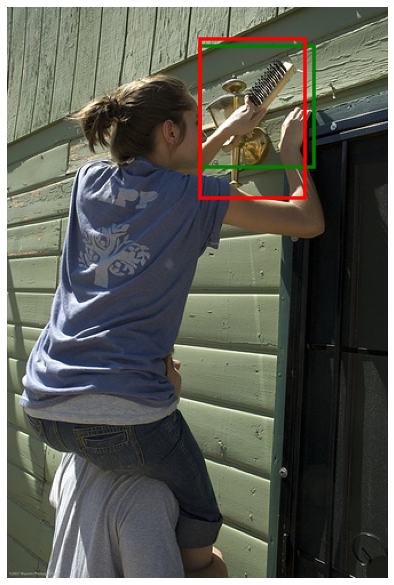

  0%|                                                  | 0/1547 [00:00<?, ?it/s]

===GT info 841===
dataset name: flickr
A woman is holding a cleaning<mask> while someone is holding her up over a door frame.
brush
===Prediction===
{'ppl': 545787.6249999997, 'all_iou': tensor([[0.7087]], device='cuda:0'), 'any_iou': [0.7087278962135315]}
[{'prob': 0.37558433413505554,
  'rank': 1,
  'rev_cap': 'A woman is holding a cleaning machine while someone is holding '
             'her up over a door frame.',
  'tokens': [' machine'],
  'tokens_ids': (3563,),
  'tokens_rel_rank': (0,)},
 {'prob': 0.05163026601076126,
  'rank': 2,
  'rev_cap': 'A woman is holding a cleaning pot while someone is holding her '
             'up over a door frame.',
  'tokens': [' pot'],
  'tokens_ids': (4728,),
  'tokens_rel_rank': (1,)},
 {'prob': 0.03747955337166786,
  'rank': 3,
  'rev_cap': 'A woman is holding a cleaning object while someone is holding '
             'her up over a door frame.',
  'tokens': [' object'],
  'tokens_ids': (7626,),
  'tokens_rel_rank': (2,)},
 {'prob': 0.030589921

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_470095/1381892889.py:38 in <cell line: 38>                                        │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_470095/1381892889.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_470095/3483130529.py:70 in mean                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_470095/3483130529.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ZeroDivisionError: division by zero

In [132]:
# dpid = choice(range(len(dataset)))
any_ious = []
ppls = []
Shuffle = True
for dpid in tqdm(range(len(dataset))):
    if Shuffle:
        dpid = choice(range(len(data['tests'])))
    dp = dataset[dpid]
    cap = dp['text_info']['caption']
    word_spans = dp['text_info']['word_spans']
    input_encs = mask_and_tokenize([cap], [word_spans], tokenizer)[0]
    unmask_token = tokenizer.decode(input_encs.input_ids[0][1:-1])
    top10_infos, proposed_bboxs, scores = infer_dp(model, dp, device= 'cuda')
    if Shuffle:
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.imshow(dp['img'])
        ax = plt.gca()
        for bbox in dp['bboxs'][0]:
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='green', linewidth=3.5)
            # rect = Rectangle((bbox[0], bbox[1]), bbox[2]- bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=3.5)
            ax.add_patch(rect)
        for bbox in proposed_bboxs.cpu():
            rect = Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=3.5)
            ax.add_patch(rect)
        plt.axis('off')
        plt.show()
        print(f"===GT info {dpid}===") 
        print(f"dataset name: {dp['dataset_name']}")
        print(tokenizer.decode(input_encs.input_ids[0][1:-1]))
        print(dp['text_info']['mask_regions'][0][1])
        print("===Prediction===")
        print(scores)
        pprint(top10_infos)
        break
    ppls.append(scores['ppl'])
    any_ious += scores['any_iou']
print(mean(any_ious))

#print(np.log(geometric_mean(ppls))

In [71]:
dp_id

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_470095/4166374766.py:1 in <cell line: 1>                                          │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_470095/4166374766.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dp_id' is not defined